<a href="https://colab.research.google.com/github/reveondivad/ExData_Plotting1/blob/master/Copy_of_Image_GPT_Sample_with_Conditioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image GPT [https://openai.com/blog/image-gpt/](https://openai.com/blog/image-gpt/)

Barebones demo, this just samples 32x32 images. That site shows lovely 64x64 images but the XL sized model isn't available. (Yet?)

(Runtime)->(Run All) will work unless you get really unlucky with the GPU.

Notebook by [https://twitter.com/jonathanfly](https://twitter.com/jonathanfly)

Notebook modified to include conditional input by [DJ AI](https://www.youtube.com/channel/UCSCsepHfXkTxivPAPZFjosg)

# Download Image-GPT

In [ ]:
!nvidia-smi #OpenAI says you need 16GB GPU for the large model, but it may work if you lower n_sub_batch on the others.

Tue Nov  3 20:11:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/openai/image-gpt.git
!pip install tensorflow-gpu==1.15.0

Cloning into 'image-gpt'...
remote: Enumerating objects: 41, done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 41
Unpacking objects: 100% (41/41), done.
     |████████████████████████████████| 411.5MB 35kB/s 
     |████████████████████████████████| 3.8MB 52.2MB/s 
     |████████████████████████████████| 512kB 49.4MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=54fe44861c5d05ce40b5c85dfaccee50e5e42dd40dfaab66c1acde649d954e56
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estim

In [ ]:
%cd /content/image-gpt

/content/image-gpt


In [ ]:
model_sizes = ["s", "m", "l"] #small medium large, xl not available
model_sizes = ["s"] #actually just download one
n_sub_batch = 8 #8 is default, trying lowering if this doesn't work.
n_px = 32
n_gpu = 1

In [ ]:
!mkdir -p /content/image-gpt/models
!mkdir -p /content/image-gpt/clusters
!mkdir -p /content/image-gpt/datasets

for model_size in model_sizes:
    !mkdir -p ./models/{model_size}
    !python download.py --model {model_size} --ckpt 1000000 --download_dir ./models/{model_size} #models
    #!python download.py --dataset imagenet --download_dir ./datasets/{model_size} #dataset
    !python download.py --clusters --download_dir ./clusters/{model_size} #color clusters

input args:
 {
    "download_dir":"./models/s",
    "model":"s",
    "ckpt":"1000000",
    "clusters":false,
    "dataset":null
}
Fetching model.ckpt-1000000.data-00000-of-00032: 1.00kit [00:00, 790kit/s]      
Fetching model.ckpt-1000000.data-00001-of-00032: 31.5Mit [00:00, 34.8Mit/s]     
Fetching model.ckpt-1000000.data-00002-of-00032: 28.3Mit [00:00, 42.6Mit/s]     
Fetching model.ckpt-1000000.data-00003-of-00032: 28.3Mit [00:01, 25.5Mit/s]     
Fetching model.ckpt-1000000.data-00004-of-00032: 28.3Mit [00:00, 30.5Mit/s]     
Fetching model.ckpt-1000000.data-00005-of-00032: 31.5Mit [00:00, 45.1Mit/s]     
Fetching model.ckpt-1000000.data-00006-of-00032: 30.4Mit [00:01, 25.3Mit/s]     
Fetching model.ckpt-1000000.data-00007-of-00032: 28.3Mit [00:00, 36.9Mit/s]     
Fetching model.ckpt-1000000.data-00008-of-00032: 31.5Mit [00:01, 27.9Mit/s]     
Fetching model.ckpt-1000000.data-00009-of-00032: 29.4Mit [00:00, 38.6Mit/s]     
Fetching model.ckpt-1000000.data-00010-of-00032: 31.5Mit [00

In [ ]:
model_size = "s"

# Setup cropped images for conditioning

In [ ]:
#numpy implementation of functions in src/utils which convert pixels of image to nearest color cluster. 
def normalize_img(img):
  return img/127.5 - 1

def squared_euclidean_distance_np(a,b):
  b = b.T
  a2 = np.sum(np.square(a),axis=1)
  b2 = np.sum(np.square(b),axis=0)
  ab = np.matmul(a,b)
  d = a2[:,None] - 2*ab + b2[None,:]
  return d

def color_quantize_np(x, clusters):
    x = x.reshape(-1, 3)
    d = squared_euclidean_distance_np(x, clusters)
    return np.argmin(d,axis=1)

In [ ]:
#get images
!curl https://i.imgur.com/vF56Fsib.jpg > kp.jpg
image_paths = ["kp.jpg"]*(n_gpu*n_sub_batch)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5515  100  5515    0     0   141k      0 --:--:-- --:--:-- --:--:--  145k


In [ ]:
#Resize original images to n_px by n_px
import cv2
import numpy as np
dim=(n_px,n_px)

x = np.zeros((n_gpu*n_sub_batch,n_px,n_px,3),dtype=np.uint8)

for n,image_path in enumerate(image_paths):
  img_np = cv2.imread(image_path)   # reads an image in the BGR format
  img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB
  H,W,C = img_np.shape
  D = min(H,W)
  img_np = img_np[:D,:D,:C] #get square piece of image
  x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px
  

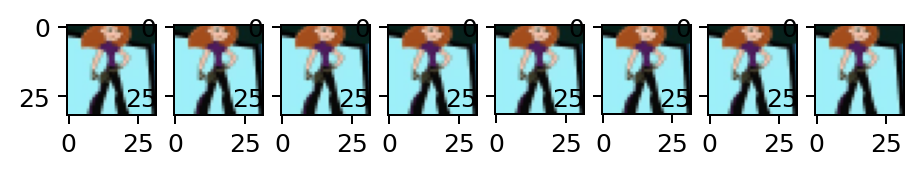

In [ ]:
#visualize resized images
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f, axarr = plt.subplots(1,8,dpi=180)

i = 0
for img in x:
    axarr[i].imshow(img)
    i += 1

In [ ]:
#use Image-GPT color palette and crop images

color_cluster_path = "/content/image-gpt/clusters/%s/kmeans_centers.npy"%(model_size)
clusters = np.load(color_cluster_path) #get color clusters
x_norm = normalize_img(x) #normalize pixels values to -1 to +1

samples = color_quantize_np(x_norm,clusters).reshape(x_norm.shape[:-1]) #map pixels to closest color cluster

n_px_crop = 8
primers = samples.reshape(-1,n_px*n_px)[:,:n_px_crop*n_px] # crop top n_px_crop rows

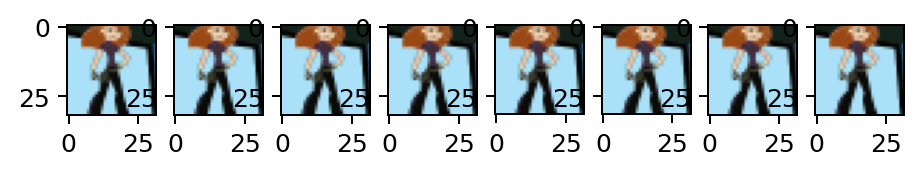

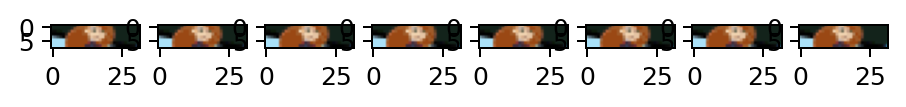

In [ ]:

#visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color clusters back to pixels
primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,n_px, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels

f, axarr2 = plt.subplots(1,8,dpi=180)
i = 0
for img in samples_img:
    axarr2[i].imshow(img)
    i += 1

f, axarr = plt.subplots(1,8,dpi=180)
i = 0
for img in primers_img:
    axarr[i].imshow(img)
    i += 1

# Functions from run.py


In [ ]:

import argparse
import json
import math
import os
import random
import sys
import time
sys.path.append('src')

import numpy as np
import tensorflow as tf

from imageio import imwrite
from scipy.special import softmax
from tensorflow.contrib.training import HParams
from tqdm import tqdm

from model import model
from utils import iter_data, count_parameters


def parse_arguments():
    parser = argparse.ArgumentParser()

    # data and I/O
    parser.add_argument("--data_path", type=str, default="/root/downloads/imagenet")
    parser.add_argument("--ckpt_path", type=str, default="/root/downloads/model.ckpt-1000000")
    parser.add_argument("--color_cluster_path", type=str, default="/root/downloads/kmeans_centers.npy")
    parser.add_argument("--save_dir", type=str, default="/root/save/")

    # model
    parser.add_argument("--n_embd", type=int, default=512)
    parser.add_argument("--n_head", type=int, default=8)
    parser.add_argument("--n_layer", type=int, default=24)
    parser.add_argument("--n_px", type=int, default=32, help="image height or width in pixels")
    parser.add_argument("--n_vocab", type=int, default=512, help="possible values for each pixel")

    parser.add_argument("--bert", action="store_true", help="use the bert objective (defaut: autoregressive)")
    parser.add_argument("--bert_mask_prob", type=float, default=0.15)
    parser.add_argument("--clf", action="store_true", help="add a learnable classification head")

    # parallelism
    parser.add_argument("--n_sub_batch", type=int, default=8, help="per-gpu batch size")
    parser.add_argument("--n_gpu", type=int, default=8, help="number of gpus to distribute training across")

    # mode
    parser.add_argument("--eval", action="store_true", help="evaluates the model, requires a checkpoint and dataset")
    parser.add_argument("--sample", action="store_true", help="samples from the model, requires a checkpoint and clusters")

    # reproducibility
    parser.add_argument("--seed", type=int, default=42, help="seed for random, np, tf")

    args = parser.parse_args()
    print("input args:\n", json.dumps(vars(args), indent=4, separators=(",", ":")))
    return args


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)


def load_data(data_path):
    trX = np.load(f'{data_path}_trX.npy')
    trY = np.load(f'{data_path}_trY.npy')
    vaX = np.load(f'{data_path}_vaX.npy')
    vaY = np.load(f'{data_path}_vaY.npy')
    teX = np.load(f'{data_path}_teX.npy')
    teY = np.load(f'{data_path}_teY.npy')
    return (trX, trY), (vaX, vaY), (teX, teY)


def set_hparams(args):
    return HParams(
        n_ctx=args.n_px*args.n_px,
        n_embd=args.n_embd,
        n_head=args.n_head,
        n_layer=args.n_layer,
        n_vocab=args.n_vocab,
        bert=args.bert,
        bert_mask_prob=args.bert_mask_prob,
        clf=args.clf,
    )


def create_model(x, y, n_gpu, hparams):
    gen_logits = []
    gen_loss = []
    clf_loss = []
    tot_loss = []
    accuracy = []

    trainable_params = None
    for i in range(n_gpu):
        with tf.device("/gpu:%d" % i):
            results = model(hparams, x[i], y[i], reuse=(i != 0))

            gen_logits.append(results["gen_logits"])
            gen_loss.append(results["gen_loss"])
            clf_loss.append(results["clf_loss"])

            if hparams.clf:
                tot_loss.append(results["gen_loss"] + results["clf_loss"])
            else:
                tot_loss.append(results["gen_loss"])

            accuracy.append(results["accuracy"])

            if i == 0:
                trainable_params = tf.trainable_variables()
                print("trainable parameters:", count_parameters())

    return trainable_params, gen_logits, gen_loss, clf_loss, tot_loss, accuracy


def reduce_mean(gen_loss, clf_loss, tot_loss, accuracy, n_gpu):
    with tf.device("/gpu:0"):
        for i in range(1, n_gpu):
            gen_loss[0] += gen_loss[i]
            clf_loss[0] += clf_loss[i]
            tot_loss[0] += tot_loss[i]
            accuracy[0] += accuracy[i]
        gen_loss[0] /= n_gpu
        clf_loss[0] /= n_gpu
        tot_loss[0] /= n_gpu
        accuracy[0] /= n_gpu


def evaluate(sess, evX, evY, X, Y, gen_loss, clf_loss, accuracy, n_batch, desc, permute=False):
    metrics = []
    for xmb, ymb in iter_data(evX, evY, n_batch=n_batch, truncate=True, verbose=True):
        metrics.append(sess.run([gen_loss[0], clf_loss[0], accuracy[0]], {X: xmb, Y: ymb}))
    eval_gen_loss, eval_clf_loss, eval_accuracy = [np.mean(m) for m in zip(*metrics)]
    print(f"{desc} gen: {eval_gen_loss:.4f} clf: {eval_clf_loss:.4f} acc: {eval_accuracy:.2f}")


# naive sampler without caching
def sample(sess, X, gen_logits, n_sub_batch, n_gpu, n_px, n_vocab, clusters, save_dir,primers=None):
  
    samples = np.zeros([n_gpu * n_sub_batch, n_px * n_px], dtype=np.int32)

    if primers is None:
      N_cond_px = 0
    else:
      N_cond_px = primers.shape[1]
      samples[:,:N_cond_px] = primers
      

    print('Conditioning on %d out of %d pixels'%(N_cond_px,n_px*n_px))
    for i in tqdm(range(N_cond_px,n_px * n_px), ncols=80, leave=False):
        np_gen_logits = sess.run(gen_logits, {X: samples})
        for j in range(n_gpu):
            p = softmax(np_gen_logits[j][:, i, :], axis=-1)  # logits to probas
            for k in range(n_sub_batch):
                c = np.random.choice(n_vocab, p=p[k])  # choose based on probas
                samples[j * n_sub_batch + k, i] = c
    
    # dequantize
    samples = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [32, 32, 3]).astype(np.uint8) for s in samples]

    # write to png
    for i in range(n_gpu * n_sub_batch):
        imwrite(f"{args.save_dir}/seed_{args.seed}_sample_{i}.png", samples[i])


def main(args,primers=None):
    tf.reset_default_graph()
    set_seed(args.seed)

    n_batch = args.n_sub_batch * args.n_gpu

    if args.sample:
        n_class = 1000
        print("Skipping dataset requirement for sampling.")
    else:
        if args.data_path.endswith("cifar10"):
            n_class = 10
        elif args.data_path.endswith("imagenet"):
            n_class = 1000
        else:
            raise ValueError("Dataset not supported.")

    X = tf.placeholder(tf.int32, [n_batch, args.n_px * args.n_px])
    Y = tf.placeholder(tf.float32, [n_batch, n_class])

    x = tf.split(X, args.n_gpu, 0)
    y = tf.split(Y, args.n_gpu, 0)

    hparams = set_hparams(args)
    trainable_params, gen_logits, gen_loss, clf_loss, tot_loss, accuracy = create_model(x, y, args.n_gpu, hparams)
    reduce_mean(gen_loss, clf_loss, tot_loss, accuracy, args.n_gpu)

    saver = tf.train.Saver(var_list=[tp for tp in trainable_params if not 'clf' in tp.name])
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)) as sess:
        sess.run(tf.global_variables_initializer())

        saver.restore(sess, args.ckpt_path)

        if args.eval:
            (trX, trY), (vaX, vaY), (teX, teY) = load_data(args.data_path)
            evaluate(sess, trX[:len(vaX)], trY[:len(vaY)], X, Y, gen_loss, clf_loss, accuracy, n_batch, "train")
            evaluate(sess, vaX, vaY, X, Y, gen_loss, clf_loss, accuracy, n_batch, "valid")
            evaluate(sess, teX, teY, X, Y, gen_loss, clf_loss, accuracy, n_batch, "test")

        if args.sample:
            if not os.path.exists(args.save_dir):
                os.makedirs(args.save_dir)
            clusters = np.load(args.color_cluster_path)
            sample(sess, X, gen_logits, args.n_sub_batch, args.n_gpu, args.n_px, args.n_vocab, clusters, args.save_dir,primers=primers)



# Sample

In [ ]:
#set model hyperparameters
MODELS={"l":(1536,16,48),"m":(1024,8,36),"s":(512,8,24) }
n_embd,n_head,n_layer=MODELS[model_size]

In [ ]:

sys.argv="""src/run.py  --sample --n_embd %d --n_head %d --n_layer %d
--ckpt_path /content/image-gpt/models/%s/model.ckpt-1000000 --color_cluster_path /content/image-gpt/clusters/%s/kmeans_centers.npy 
--data_path /content/image-gpt/datasets/s/imagenet_notused --save_dir /content/image-gpt/output 
--n_gpu %d --n_px %d --n_sub_batch %d --seed 42"""%(n_embd,n_head,n_layer,model_size,model_size,n_gpu,n_px,n_sub_batch)

sys.argv=sys.argv.split()

args = parse_arguments()

main(args,primers=primers) #conditional generation
#main(args) #unconditional generation

input args:
 {
    "data_path":"/content/image-gpt/datasets/s/imagenet_notused",
    "ckpt_path":"/content/image-gpt/models/s/model.ckpt-1000000",
    "color_cluster_path":"/content/image-gpt/clusters/s/kmeans_centers.npy",
    "save_dir":"/content/image-gpt/output",
    "n_embd":512,
    "n_head":8,
    "n_layer":24,
    "n_px":32,
    "n_vocab":512,
    "bert":false,
    "bert_mask_prob":0.15,
    "clf":false,
    "n_sub_batch":8,
    "n_gpu":1,
    "eval":false,
    "sample":true,
    "seed":42
}
Skipping dataset requirement for sampling.



trainable parameters: 76571648
INFO:tensorflow:Restoring parameters from /content/image-gpt/models/s/model.ckpt-1000000


  0%|                                                   | 0/768 [00:00<?, ?it/s]

Conditioning on 256 out of 1024 pixels


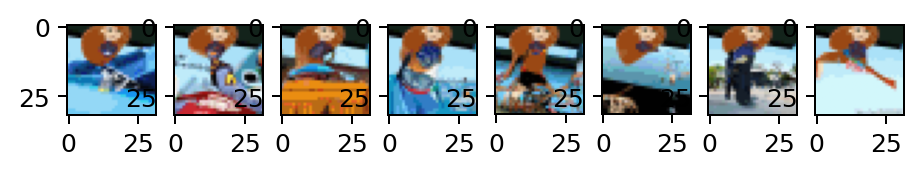

In [ ]:
#visualize output samples
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

samples = pathlib.Path('/content/image-gpt/output').glob('*.png')

f, axarr = plt.subplots(1,len(glob.glob('/content/image-gpt/output/*.png')),dpi=180)

i = 0
for image in samples:
    axarr[i].imshow(mpimg.imread(image))
    i += 1